# Installations
----

In [1]:
%%capture --no-display
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git';

# Imports and Initialization
----

In [2]:
import os
import cv2
import pandas as pd
from IPython.display import Image
from matplotlib import pyplot as plt

# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer

from sklearn.preprocessing import MinMaxScaler

In [3]:
cfg = get_cfg()
best_model = "COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml"
# fast_model = "COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file(best_model)) # we can change the path here
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(best_model) # we can change the path here
predictor = DefaultPredictor(cfg)

[01/07 16:36:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x/139686956/model_final_5ad38f.pkl ...


In [4]:
# helper for displaying images in ipynb
def show_rgb_image(image, title=None, conversion=cv2.COLOR_BGR2RGB):

    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV
    image = cv2.cvtColor(image, conversion)

    # Show the image
    plt.imshow(image)

    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])

    # if a title is provided, show it
    if title is not None:
        plt.title(title)

    plt.show()

# Keypoint Exploration
----

First let's take a look at an image. This example is a clear image that displays the entire human within frame very clearly.

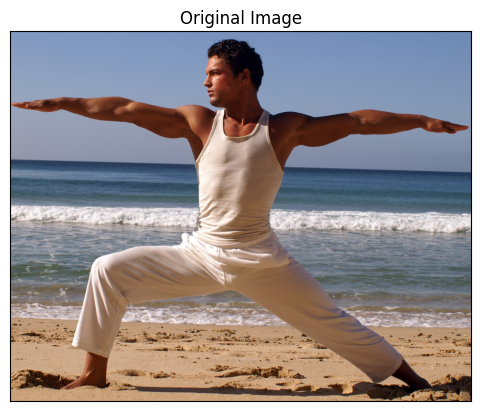

In [5]:
file = "dataset-for-classification/virabhadrasana-ii/f4a45728f95750eb7796565d90b2d81bfdf7157bf5bfe340b42840c650f30347.png"
im = cv2.imread(file)
show_rgb_image(im, 'Original Image')

To get an idea of what the keypoints for this image looks like, we can use the Recurrent Neural Network that has been trained on the COCO dataset to inference where the keypoints are on the image and display the image with them painted on the image.

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


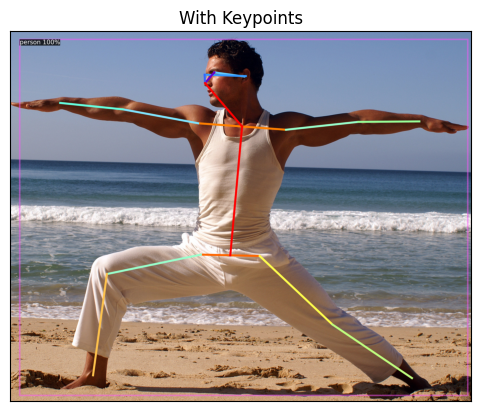

In [6]:
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.5)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show_rgb_image(v.get_image()[:, :, ::-1], "With Keypoints")

This helper function uses the inferenced x and y cordinates on the image to draw a very basic skeleton. If there is more than one human featured in the image, we will see several skeletons draw, one over each human. So we will only focus on the main human in the image `outputs["instances"][0]`. Let's see what keypoints are used to draw the basic skeleton:

In [7]:
MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).keypoint_names

('nose',
 'left_eye',
 'right_eye',
 'left_ear',
 'right_ear',
 'left_shoulder',
 'right_shoulder',
 'left_elbow',
 'right_elbow',
 'left_wrist',
 'right_wrist',
 'left_hip',
 'right_hip',
 'left_knee',
 'right_knee',
 'left_ankle',
 'right_ankle')

If we view the predicted keypoint outputs, we get tensors:

In [8]:
outputs["instances"][0].pred_keypoints[0, :, :3]

tensor([[8.8408e+02, 2.3591e+02, 4.0431e+00],
        [9.2604e+02, 1.8767e+02, 1.7618e+00],
        [8.8198e+02, 1.9816e+02, 2.2793e+00],
        [1.0624e+03, 2.0655e+02, 2.5861e+00],
        [1.0687e+03, 2.0445e+02, 8.4850e-01],
        [1.2512e+03, 4.4775e+02, 7.8024e-01],
        [8.5261e+02, 4.1839e+02, 9.8227e-01],
        [1.5785e+03, 4.1209e+02, 3.5284e+00],
        [5.1273e+02, 3.5546e+02, 2.7867e+00],
        [1.8555e+03, 4.1000e+02, 3.0452e+00],
        [2.2739e+02, 3.2610e+02, 9.3605e-01],
        [1.1317e+03, 1.0203e+03, 9.7321e-01],
        [8.6520e+02, 1.0141e+03, 6.7196e-01],
        [1.4610e+03, 1.3308e+03, 8.2597e-01],
        [4.3929e+02, 1.1021e+03, 1.4635e+00],
        [1.8219e+03, 1.5741e+03, 4.9407e-01],
        [3.7635e+02, 1.5615e+03, 8.1071e-01]], device='cuda:0')

In order to utilze these keypoints to do some basic modelling, we need the x and y coordinates of each point. An output of this model is that each keypoint has an X and Y as well as a confidence interval. We will need to do some funky numpy conversion to get X, Y as a number. We will also perform MinMax scaling on each keypoint because each image may have different height and width. We want our features to mean more or less the same thing when we perform modeling so we will scale the X, Y coordinates.

These helper functions will provide both the pixel location and the scaled values for each image:

In [9]:
# returns scaled keypoints in image - may help with classification - TBD
def keypoints_and_min_max_scale(keypoints):
    keypoints_x = keypoints[:, 0:1].cpu().detach().numpy()
    keypoints_y = keypoints[:, 1:2].cpu().detach().numpy()
    score_x_y = keypoints[:, 2:3].cpu().detach().numpy()

    pixel_keypoints = [[keypoints_x[i][0], keypoints_y[i][0], score_x_y[i][0]] for i in range(len(keypoints_x))]

    # scale the keypoints
    scaler = MinMaxScaler()
    scaled_x = scaler.fit_transform(keypoints_x)
    scaled_y = scaler.fit_transform(keypoints_y)

    scaled_keypoints = [[scaled_x[i][0], scaled_y[i][0], score_x_y[i][0]] for i in range(len(scaled_x))]
    return {
        "pixel": pixel_keypoints,
        "scaled": scaled_keypoints
    }

In [10]:
def predict_keypoints_and_format(path_to_img_file):
    im = cv2.imread(path_to_img_file)
    outputs = predictor(im)
    if len(outputs["instances"]):
        # use the keypoints of only the main person in the photo
        keypoints = outputs["instances"][0].pred_keypoints[0, :, :3]
        # worth trying to store the tensor to a file?
        return keypoints_and_min_max_scale(keypoints)
        
    else:
        raise Exception("This file did not find any human to inference keypoints from. Try lowering the threshold")

In [11]:
keypoints_x_y = predict_keypoints_and_format(file)
keypoints_x_y["pixel"]

[[884.08215, 235.91057, 4.043125],
 [926.04333, 187.66975, 1.7618068],
 [881.9841, 198.15689, 2.2793338],
 [1062.4172, 206.5466, 2.5861166],
 [1068.7114, 204.44917, 0.8484959],
 [1251.2428, 447.7507, 0.7802382],
 [852.61127, 418.38672, 0.9822681],
 [1578.5402, 412.09442, 3.5283508],
 [512.7254, 355.46393, 2.7867014],
 [1855.4843, 409.997, 3.0451612],
 [227.38918, 326.09995, 0.9360541],
 [1131.6533, 1020.34827, 0.9732131],
 [865.1996, 1014.05597, 0.6719577],
 [1461.0488, 1330.7676, 0.82597095],
 [439.2933, 1102.148, 1.4635164],
 [1821.915, 1574.0691, 0.49407378],
 [376.35147, 1561.4844, 0.8107115]]

In [12]:
keypoints_x_y["scaled"]

[[0.40335053, 0.03479576, 4.043125],
 [0.4291237, 0.0, 1.7618068],
 [0.40206182, 0.0075643063, 2.2793338],
 [0.5128865, 0.013615742, 2.5861166],
 [0.51675254, 0.012102887, 0.8484959],
 [0.628866, 0.18759456, 0.7802382],
 [0.38402063, 0.16641453, 0.9822681],
 [0.82989687, 0.16187593, 3.5283508],
 [0.17525771, 0.12102875, 2.7867014],
 [1.0, 0.16036308, 3.0451612],
 [0.0, 0.09984872, 0.9360541],
 [0.55541235, 0.60060513, 0.9732131],
 [0.39175254, 0.5960665, 0.6719577],
 [0.757732, 0.8245084, 0.82597095],
 [0.13015464, 0.6596067, 1.4635164],
 [0.97938126, 1.0, 0.49407378],
 [0.09149484, 0.9909227, 0.8107115]]

Some images may not return keypoints. Detectron is not able to locate a human in the image or the file format is not compatible with Detectron. Here is an example of an image that does not return a successful keypoint array:

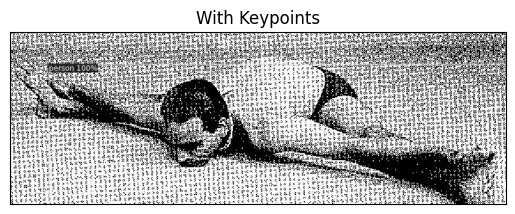

In [13]:
file = "dataset-for-classification/upavistha-konasana/ed9c2c69582e897aa6d2f0b1ed229cca6e6a1130d7d136d2a994fc051dc0a884.png"
im = cv2.imread(file)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.5)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show_rgb_image(v.get_image()[:, :, ::-1], "With Keypoints")

Detectron found a person, but it cannot accurately estimate the keypoints so it will not even try. In these instances we need to ignore the image as we will not be able to use them for our model.

# Generate Keypoints for Each Image
----

Now we need to generate the dataframe of keypoints to do basic modelling.

In [27]:
names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).keypoint_names
x_y_names = []
for n in names:
    x_y_names.append(n + '_pixel_x')
    x_y_names.append(n + '_pixel_y')
    x_y_names.append(n + '_scaled_x')
    x_y_names.append(n + '_scaled_y')
    x_y_names.append(n + '_score')
df = pd.DataFrame(columns=x_y_names + ["pose"])

In [28]:
df

,nose_pixel_x,nose_pixel_y,nose_scaled_x,nose_scaled_y,nose_score,left_eye_pixel_x,left_eye_pixel_y,left_eye_scaled_x,left_eye_scaled_y,left_eye_score,...,left_ankle_pixel_y,left_ankle_scaled_x,left_ankle_scaled_y,left_ankle_score,right_ankle_pixel_x,right_ankle_pixel_y,right_ankle_scaled_x,right_ankle_scaled_y,right_ankle_score,pose


Now that we have our dataframe we need to populate it. One thing we may want to do in order to increase the instances we have is to flip the image on the Y axis as well. Theoretically humans can perform the action facing either direction, left or right. Doing so will help prevent overfitting of a model in case most of the images are facing one direction.

In [16]:
def add_keypoint_instance_to_df(file_name, keypoints, pose):
    for keypoint in keypoints:
        for index, name in enumerate(names):
            column_name = f"{name}_{keypoint}"
            df.loc[file_name, column_name + '_x'] = keypoints[keypoint][index][0]
            df.loc[file_name, column_name + '_y'] = keypoints[keypoint][index][1]
            df.loc[file_name, name + '_score'] = keypoints[keypoint][index][2]
            df.loc[file_name, "pose"] = pose
    

In [17]:
# this will take ~30min to run
# build keypoints dataset
directory = "./dataset-for-classification/"
problem_files = []
for dir in os.listdir(directory):
    if not dir.startswith('.'):
        for file in os.listdir(directory + dir):
            try:
                full_file_location = f"{directory}{dir}/{file}"
                keypoints = predict_keypoints_and_format(full_file_location)
                add_keypoint_instance_to_df(full_file_location, keypoints, dir)
                
                # create a version flipped on the y axis via cv2
                # image = cv2.imread(full_file_location)
                # flipped_image = cv2.flip(image, 1)
                # file_name_vals = full_file_location.split('.')
                flipped_file_location = f".{file_name_vals[1]}-flipped.{file_name_vals[2]}"
                # cv2.imwrite(flipped_file_location, flipped_image)
                keypoints_x_y = predict_keypoints_and_format(flipped_file_location)
                add_keypoint_instance_to_df(flipped_file_location, keypoints, dir)
                
            except Exception as e:
                # print(f"There was an error with file: {full_file_location}. {e}")
                problem_files.append(f"{full_file_location}")

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: cHRM: inconsistent chromaticities
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


All the images with unsuccessful keypoints are now saved in a list. We need to get a sense of how many images were unsuccessful in obtaining keypoints:

In [18]:
len(problem_files)

148

Let's remove these files from our main dataset and compare image counts now that we have images we are not able to get keypoints from.

In [20]:
invalid_dir = "./dataset-no-keypoints"
os.mkdir(invalid_dir)
for file in problem_files:
    parts = file.split("/")
    pose = parts[2]
    filename = parts[3]
    target_dir = f"{invalid_dir}/{pose}"
    target_location = f"{target_dir}/{filename}"
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)
    os.rename(file, target_location)

In [21]:
# get image counts after moving images that cannot get keypoints out
img_counts = {}
parent_dir = "./dataset-for-classification/"
for dir in os.listdir(parent_dir):
    if not dir.startswith('.'):
        img_counts[dir] = len(os.listdir(parent_dir + dir))


for key in img_counts:
    if img_counts[key] < 100:
        print(f"Pose {key} now {img_counts[key]} images")

Pose sukhasana now 98 images
Pose tadasana now 96 images
Pose uttana-shishosana now 94 images
Pose vajrasana now 96 images
Pose virasana now 98 images


These are all so close to 100 (50 * 2 since we want the flipped options as well), that I am going to keep them. What I do need to do however, it remove the images from the dataframe since they will not be of service to us when it comes time to run our neural network on these instances.

In [22]:
df.head()

,nose_pixel_x,nose_pixel_y,nose_scaled_x,nose_scaled_y,nose_score,left_eye_pixel_x,left_eye_pixel_y,left_eye_scaled_x,left_eye_scaled_y,left_eye_score,...,left_ankle_pixel_y,left_ankle_scaled_x,left_ankle_scaled_y,left_ankle_score,right_ankle_pixel_x,right_ankle_pixel_y,right_ankle_scaled_x,right_ankle_scaled_y,right_ankle_score,pose
./dataset-for-classification/supta-matsyendrasana/46a4ab66d050f9f6570ffd40f061c51f7b04af3da891c1da1ad293df25f17f9a.png,202.175171,298.778473,0.069002,0.495455,1.030708,165.459946,285.511627,0.019108,0.469697,0.881244,...,57.634674,1.0,0.027273,0.227953,887.26593,57.634674,1.0,0.027273,0.343377,supta-matsyendrasana
./dataset-for-classification/adho-mukha-vrksasana/590b6ca754be92a8d9ecb9e894e11c937818b7cec5819dba7ec0dc4ba8e6815f-flipped.png,56.103966,208.161041,0.608108,0.571683,0.229484,60.726128,217.933304,0.668919,0.605521,0.172274,...,43.061104,0.445946,0.0,0.363072,85.63446,331.857391,0.996622,1.0,0.322895,adho-mukha-vrksasana
./dataset-for-classification/supta-matsyendrasana/e80b428803dbf47d229a1fbe211970e1ba36c2a5466368b1ffd0ba24a562c013.png,526.922241,37.670162,0.97799,0.0,0.84779,537.236389,49.325745,1.0,0.05317,0.824408,...,177.53714,0.231579,0.638037,0.087167,68.616028,217.435089,0.0,0.820041,0.154126,supta-matsyendrasana
./dataset-for-classification/supta-matsyendrasana/4187f021d7e3b2d92ce2bdfabb90126e0a1f648a5e846b5cd452cafa12a3761c.png,719.848267,104.002266,0.950276,0.174129,2.304453,736.857361,120.36554,1.0,0.217247,2.170392,...,402.317322,0.828729,0.960199,0.227547,680.790466,417.421875,0.836096,1.0,0.325802,supta-matsyendrasana
./dataset-for-classification/supta-matsyendrasana/8fbb0fb028119ef65cbbb6aff56ed0b6835ac79a589657f43c1d8210c23b7df2.png,81.610138,80.690689,0.041439,0.25,0.404074,66.184998,80.284561,0.0,0.248077,0.923455,...,185.47113,1.0,0.746154,0.213681,433.141022,181.409882,0.985823,0.726923,0.097591,supta-matsyendrasana


Okay, we're ready to run some modelling with this data!

In [24]:
df.to_csv("keypoints.csv")